In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os, sys
import string

from gensim import utils
from gensim.models import word2vec, keyedvectors
from gensim.test.utils import datapath, get_tmpfile, temporary_file, common_texts as sentences
from gensim.models import LdaModel
from gensim.models import LsiModel

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import spacy 
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings


In [2]:
file = 'cleaned_workorders_nov15.csv'
df_file= pd.read_csv('cleaned_workorders_nov15.csv')
# df_file.text

In [3]:
df_file.head()
cols = ['HybridID', 'text', 'ChoiceString']
df = pd.DataFrame(df_file, columns = cols)
# print(df['text'][:2500].tolist())

In [4]:
text_list = df['text'].to_string()
text_list
# texts = text_list

'0        Walk with a dog. .  walk with my dog  Can I or...\n1        .  Repair Kitchen Window  Window falls out whe...\n2        .  Fire Alarm Light bulb & plastic cover  The ...\n3        .  Main Entrance Door lock needs to be replace...\n4        .  Window Screens   For Front Bedroom and Midd...\n5        .  Dining Room Light is out - No battery  Dini...\n6        .  Running Toilet  Apartment B (1/F Rear), the...\n7        .  Repair the downstairs unit water damaged on...\n8        .  Kitchen Faucet (hot water dripping) & Toile...\n9        .  Lead Dust Cert Filing  Check with Karen to ...\n10       .  Bathroom Window leaks and tile floor cracke...\n11       .  Return Security deposit minus cleaning and ...\n12       .  Check for 10 years sealed battery  Check fo...\n13       .  Need final water bill from landlord  Need f...\n14       .  Gutter cost, refresh, paint, cleaning, gas ...\n15       .  Need fire alarm paperwork from Anthony Arma...\n16       .  Need peco paperwork from An

In [13]:
tags_list = ['<p>' ,'<* p>' , '<p*>',
             '<b>', '</b>', '\n',
             '<ul>','</ul>','<li>',
             '</li>','<br>', '</br>', 
             '-','<strong>','</strong>',
             '<span*>','</span>','<a href*>',
             '</a>', '<em>','</em>', '&', 'nbsp', '&nbsp', 'â', 'p', 'nan']

for tag in tags_list:
    df.text.replace(to_replace=tag, value='', regex=True, inplace=True)

tokens = word_tokenize(text_list)  
# convert to lower case
tokens = [w.lower() for w in tokens] # remove punctuation from each word

table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]   # remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words

stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]

words=[s for s in words if not s in tags_list]
texts = [words]
# print(texts)

In [6]:
dictionary = Dictionary(texts)
# dictionary
corpus = [dictionary.doc2bow(text) for text in texts]
# corpus

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Topic Modeling with Latent Dirichlet Allocation (LDA)


There are two layers in this model — documents and tokens — and the size or dimensionality of the document vectors is the number of tokens in the corpus vocabulary. This approach has a number of disadvantages:

* Document vectors tend to be large (one dimension for each token ⇒ lots of dimensions)
* They also tend to be very sparse. Any given document only contains a small fraction of all tokens in the vocabulary, so most values in the document's token vector are 0.
* The dimensions are fully independent from each other — there's no sense of connection between related tokens, such as knife and fork.

## LDA injects a third layer into this conceptual model. 

    Documents are represented as a mixture of a pre-defined number of topics, and the topics are represented as a mixture of the individual tokens in the vocabulary. The number of topics is a model hyper-parameter selected by me. 

### LDA makes a prior assumption that the (document, topic) and (topic, token) mixtures follow Dirichlet probability distributions. 



## This assumption encourages documents to consist mostly of a handful of topics, and topics to consist mostly of a modest set of the tokens.
   
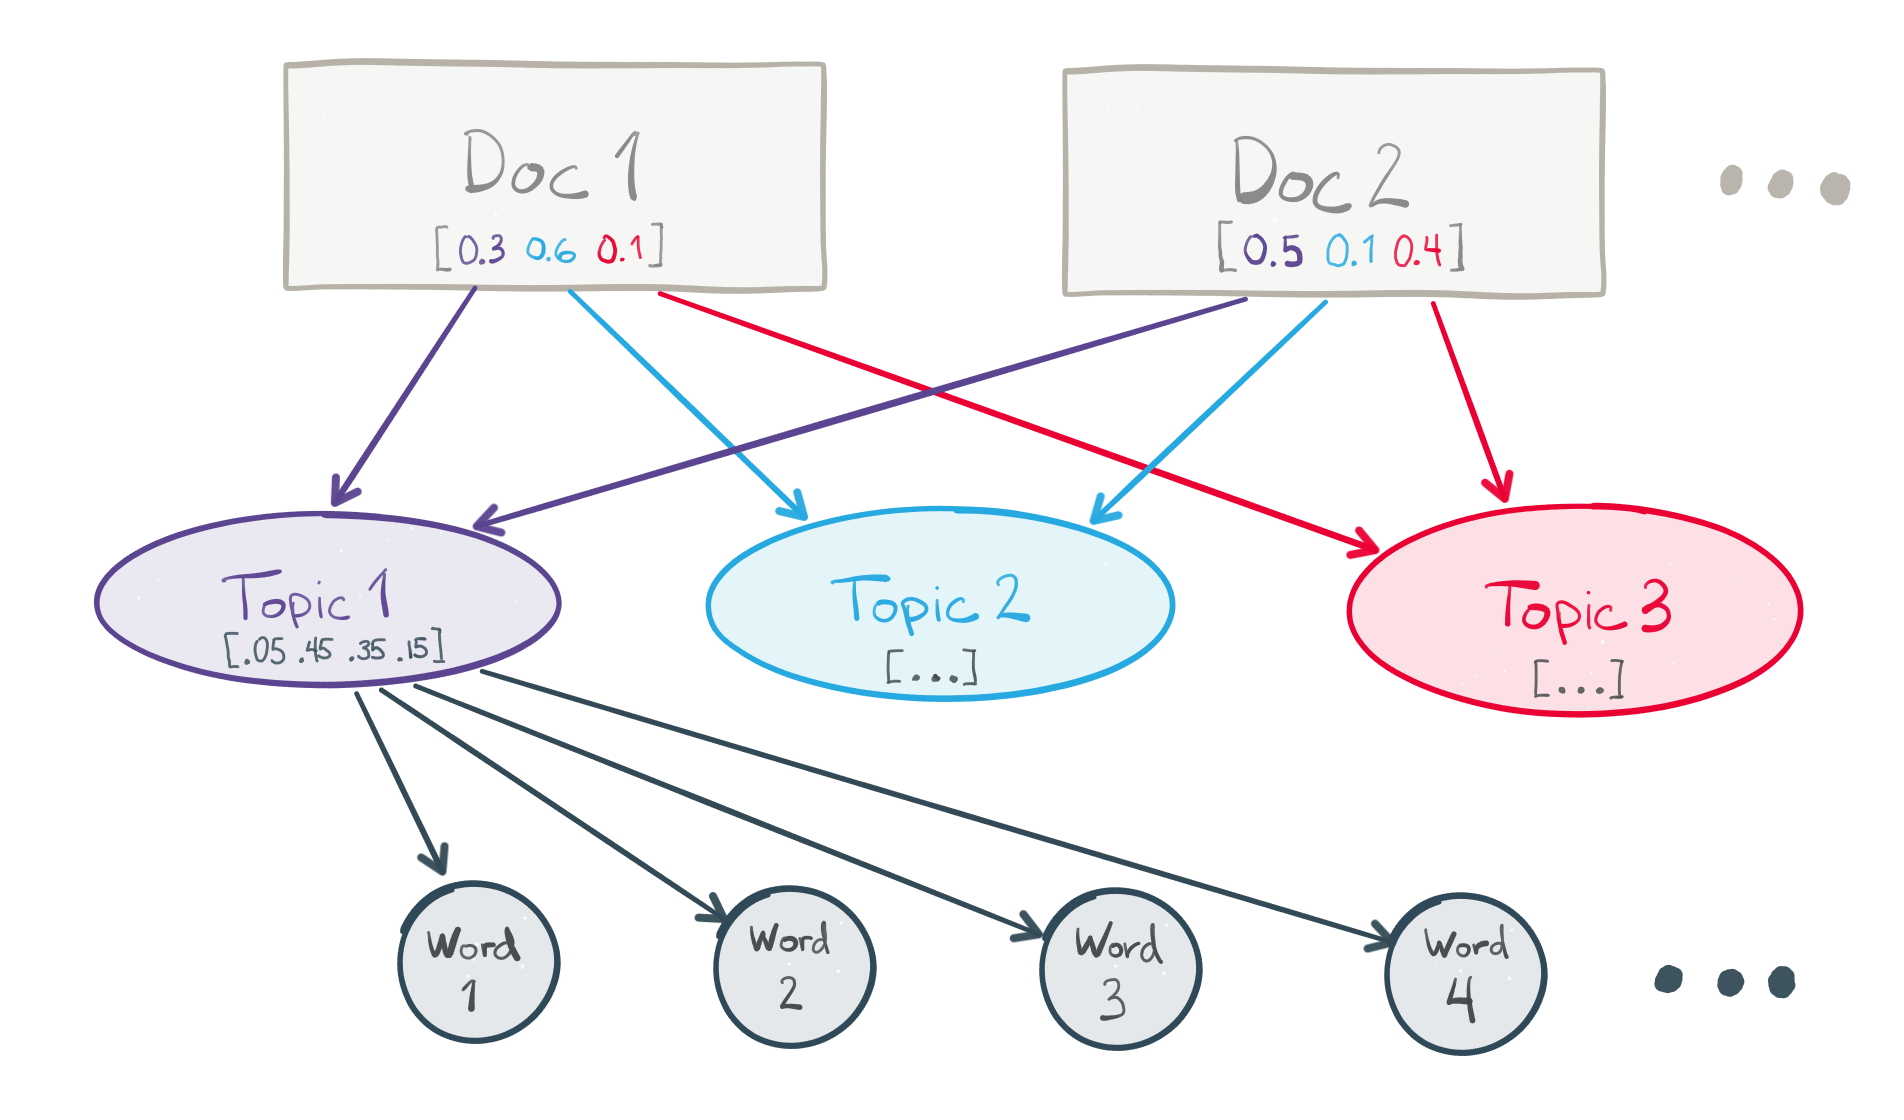
[Source](http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb#topic=0&lambda=1&term=)

In [8]:
np.random.seed(1) # setting random seed to get the same results each time.
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=30)
ldamodel.top_topics(corpus)

[([(0.017259656, 'door'),
   (0.016448947, 'water'),
   (0.014094589, 'kitchen'),
   (0.009400658, 'working'),
   (0.00878327, 'replace'),
   (0.008748789, 'needs'),
   (0.008574101, 'ac'),
   (0.008432431, 'need'),
   (0.008044791, 'leaking'),
   (0.008019682, 'bathroom'),
   (0.007423643, 'tenant'),
   (0.00731644, 'sink'),
   (0.00701993, 'toilet'),
   (0.005870474, 'leak'),
   (0.005703835, 'light'),
   (0.005551222, 'unit'),
   (0.005347853, 'room'),
   (0.00525461, 'new'),
   (0.005221681, 'air'),
   (0.0051896735, 'back')],
  1.0000889005818406e-12),
 ([(0.012178018, 'door'),
   (0.011604878, 'kitchen'),
   (0.011506881, 'leaking'),
   (0.009788029, 'needs'),
   (0.009132907, 'bathroom'),
   (0.009042634, 'replace'),
   (0.008835839, 'unit'),
   (0.008576839, 'need'),
   (0.008467101, 'ac'),
   (0.008220635, 'working'),
   (0.008096297, 'repair'),
   (0.00807816, 'sink'),
   (0.0077279964, 'toilet'),
   (0.006708423, 'water'),
   (0.00655111, 'new'),
   (0.006204741, 'light'),
 

In [9]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.004814 -0.001005       1        1  60.874939
1      0.005224  0.004455       2        1  37.257492
22     0.003498 -0.002810       3        1   1.360523
18     0.003034 -0.001059       4        1   0.297919
24     0.002934  0.001600       5        1   0.114212
0      0.002654 -0.000403       6        1   0.041066
4      0.002100 -0.000873       7        1   0.019446
26     0.002024  0.000504       8        1   0.015005
27     0.001824 -0.001262       9        1   0.008197
9      0.001789 -0.000314      10        1   0.004286
14     0.001917 -0.000293      11        1   0.003615
25     0.001289  0.000135      12        1   0.002280
16     0.001108 -0.000541      13        1   0.000487
2      0.001559  0.000311      14        1   0.000218
15     0.000877 -0.001115      15        1   0.000089
19    -0.003190  0.003963      16        1   0.000015
7     -0.001069 -0.002840      17        1   0.000015
3     -0.002425  0.000552      18        1   0.000015
23     0.000162  0.000043      19        1   0.000015
21     0.000169  0.000313      20        1   0.000015
6     -0.002181  0.000553      21        1   0.000015
20    -0.008254  0.000914      22        1   0.000015
8     -0.006798 -0.001759      23        1   0.000015
17    -0.000495 -0.000104      24        1   0.000015
10    -0.000712  0.001736      25        1   0.000015
11    -0.007486 -0.000392      26        1   0.000015
12     0.000294 -0.000486      27        1   0.000015
13    -0.002898 -0.001642      28        1   0.000015
28    -0.001878  0.001386      29        1   0.000015
29     0.000114  0.000434      30        1   0.000015, topic_info=      Category         Freq      Term        Total  loglift  logprob
term                                                                
14551  Default  3035.000000     water  3035.000000  30.0000  30.0000
3776   Default  3029.000000      door  3029.000000  29.0000  29.0000
7118   Default  2559.000000   kitchen  2559.000000  28.0000  28.0000
7436   Default  2328.000000   leaking  2328.000000  27.0000  27.0000
10952  Default  1908.000000   replace  1908.000000  26.0000  26.0000
1076   Default  1936.000000  bathroom  1936.000000  25.0000  25.0000
8782   Default  1835.000000      need  1835.000000  24.0000  24.0000
45     Default  1770.000000        ac  1770.000000  23.0000  23.0000
8788   Default  1739.000000     needs  1739.000000  22.0000  22.0000
14907  Default  1699.000000   working  1699.000000  21.0000  21.0000
13583  Default  1689.000000    toilet  1689.000000  20.0000  20.0000
10898  Default  1600.000000    repair  1600.000000  19.0000  19.0000
5290   Default  1590.000000     front  1590.000000  18.0000  18.0000
12150  Default  1568.000000      sink  1568.000000  17.0000  17.0000
14025  Default  1582.000000      unit  1582.000000  16.0000  16.0000
7581   Default  1466.000000     light  1466.000000  15.0000  15.0000
7422   Default  1329.000000      leak  1329.000000  14.0000  14.0000
13309  Default  1289.000000    tenant  1289.000000  13.0000  13.0000
8843   Default  1276.000000       new  1276.000000  12.0000  12.0000
252    Default  1250.000000       air  1250.000000  11.0000  11.0000
14796  Default  1190.000000    window  1190.000000  10.0000  10.0000
1621   Default  1102.000000    broken  1102.000000   9.0000   9.0000
12056  Default  1093.000000    shower  1093.000000   8.0000   8.0000
4875   Default  1077.000000    filter  1077.000000   7.0000   7.0000
11314  Default  1062.000000      room  1062.000000   6.0000   6.0000
2347   Default  1011.000000     clean  1011.000000   5.0000   5.0000
2071   Default  1008.000000   ceiling  1008.000000   4.0000   4.0000
6578   Default   987.000000   install   987.000000   3.0000   3.0000
895    Default   946.000000      back   946.000000   2.0000   2.0000
1177   Default   851.000000   bedroom   851.000000   1.0000   1.0000
...        ...       

## HDP the Hierarchical Dirichlet Process is an *unsupervised topic model* which figures out the number of topics on it's own.



In [10]:
from gensim.models import HdpModel
from gensim.models.wrappers import LdaMallet
import pyLDAvis.gensim

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()


[(0,
  '0.016*water + 0.014*door + 0.010*kitchen + 0.010*bathroom + 0.009*leaking + 0.009*needs + 0.009*replace + 0.008*sink + 0.008*working + 0.008*ac + 0.008*need + 0.007*unit + 0.007*toilet + 0.007*repair + 0.007*new + 0.006*leak + 0.006*tenant + 0.006*front + 0.006*light + 0.006*air'),
 (1,
  '0.000*cleand + 0.000*thermablast + 0.000*glas + 0.000*okien + 0.000*trickey + 0.000*police + 0.000*bee + 0.000*tested + 0.000*immersion + 0.000*fixt + 0.000*except + 0.000*sugg + 0.000*appare + 0.000*fam + 0.000*newphoneline + 0.000*lakeshore + 0.000*torcon + 0.000*stow + 0.000*genessee + 0.000*circuit'),
 (2,
  '0.000*getitdone + 0.000*clem + 0.000*bryson + 0.000*catches + 0.000*yemi + 0.000*escrines + 0.000*higher + 0.000*jayesh + 0.000*tubshower + 0.000*pans + 0.000*attention + 0.000*vies + 0.000*thoroughl + 0.000*modified + 0.000*loca + 0.000*unblock + 0.000*burrowing + 0.000*waste + 0.000*entrada + 0.000*laptop'),
 (3,
  '0.000*planning + 0.000*empower + 0.000*beh + 0.000*pex + 0.000*bob

In [11]:
pyLDAvis.gensim.prepare(hdpmodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster          Freq
topic                                                   
0     -0.363456 -0.000004       1        1  9.999979e+01
1      0.002007 -0.000464       2        1  1.072676e-04
2      0.002080  0.000577       3        1  5.113278e-05
3      0.002379  0.000126       4        1  2.554617e-05
4      0.002484 -0.001179       5        1  1.277308e-05
5      0.002605 -0.000359       6        1  6.386540e-06
6      0.003382  0.000534       7        1  3.193270e-06
7      0.003075  0.001270       8        1  1.596635e-06
8      0.003569  0.001555       9        1  7.983175e-07
9      0.001671 -0.000033      10        1  3.991588e-07
10     0.002323  0.000058      11        1  1.995794e-07
11     0.002928  0.000053      12        1  9.978969e-08
12     0.002454  0.001131      13        1  4.989485e-08
13     0.003271 -0.000012      14        1  2.494742e-08
14     0.002292  0.001123      15        1  1.247371e-08
15     0.003227  0.000039      16        1  6.236856e-09
16     0.001736  0.000576      17        1  3.118428e-09
17     0.001795  0.001300      18        1  1.559214e-09
18     0.002629  0.000575      19        1  7.796070e-10
19     0.003180  0.000456      20        1  3.898035e-10
20     0.002592 -0.001483      21        1  1.949017e-10
21     0.002517  0.000943      22        1  9.745087e-11
22     0.002415 -0.000353      23        1  4.872544e-11
23     0.002772 -0.000799      24        1  2.436272e-11
24     0.002286 -0.000296      25        1  1.218136e-11
25     0.002852 -0.001321      26        1  6.090679e-12
26     0.001899  0.000658      27        1  3.045340e-12
27     0.002440 -0.000824      28        1  1.522670e-12
28     0.002606 -0.000192      29        1  7.613349e-13
29     0.002455  0.000342      30        1  3.806675e-13
...         ...       ...     ...      ...           ...
120    0.002380 -0.000145     121        1  1.537504e-40
121    0.001966 -0.000408     122        1  7.687518e-41
122    0.002087 -0.000678     123        1  3.843759e-41
123    0.002425 -0.000217     124        1  1.921880e-41
124    0.002043 -0.000671     125        1  9.609398e-42
125    0.001512 -0.001681     126        1  4.804699e-42
126    0.002531 -0.000594     127        1  2.402349e-42
127    0.002487  0.000566     128        1  1.201175e-42
128    0.001986  0.000088     129        1  6.005874e-43
129    0.002312  0.000453     130        1  3.002937e-43
130    0.002362  0.000075     131        1  1.501468e-43
131    0.002036  0.000124     132        1  7.507342e-44
132    0.002615 -0.000813     133        1  3.753671e-44
133    0.002812 -0.000054     134        1  1.876836e-44
134    0.001878 -0.000479     135        1  9.384178e-45
135    0.001991 -0.000641     136        1  4.692089e-45
136    0.002314 -0.000138     137        1  2.346044e-45
137    0.002518 -0.000222     138        1  1.173022e-45
138    0.003055  0.000060     139        1  5.865111e-46
139    0.001491  0.000131     140        1  2.932555e-46
140    0.002344  0.000691     141        1  1.466278e-46
141    0.002160  0.000274     142        1  7.331389e-47
142    0.002365 -0.000680     143        1  3.665694e-47
143    0.000891  0.000493     144        1  1.832847e-47
144    0.003122 -0.000232     145        1  9.164236e-48
145    0.002459 -0.000492     146        1  4.582118e-48
146    0.002526  0.000090     147        1  2.291059e-48
147    0.001687 -0.000792     148        1  1.145529e-48
148    0.001845 -0.000681     149        1  5.727647e-49
149    0.002318 -0.000054     150        1  5.727647e-49

[150 rows x 5 columns], topic_info=       Category          Freq         Term        Total  loglift  logprob
term                                                                     
14551   Default  3.496000e+03        water  3496.000000  30.0000  30.0000
3776    Default  3.153000e+03         door  3153.000000  29.0000  29.0000
1076    Default  2.196000e+03     bathroom  21

# Wait, what am I looking at again?

#### There are a lot of moving parts in the visualization. Here's a brief summary:

* On the left, there is a plot of the __"distance" between all of the topics__ (labeled as the Intertopic Distance Map)
    * The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally __similar should be appear close together on the plot__, while dissimilar topics should appear far apart.
    * The relative __size of a topic's circle in the plot corresponds to the relative frequency of the topic__ in the corpus.
    * An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.
* On the right, there is a bar chart showing __top terms__.
    * When no topic is selected in the plot on the left, the bar chart shows the top-30 most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.
    * When a particular topic is selected, the bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λ, which can be adjusted with a slider above the bar chart.
        * Setting the λ parameter close to __1.0__ (the default) will rank the terms solely according to their __probability within the topic__.
        * Setting λ close to 0.0 will rank the terms solely according to their __"distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics__.
        * Setting λ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.
        
* Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found [here](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf). Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaMulticore object and pyLDAvis' visualization, you have to dig through the terms manually.

## Analyzing our LDA model

The interactive visualization pyLDAvis produces is helpful for both:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the λ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In our plot, there is a stark divide along the x-axis, with two topics far to the left and most of the remaining 48 far to the right. Inspecting the two outlier topics provides a plausible explanation: both topics contain many non-English words, while most of the rest of the topics are in English. So, one of the main attributes that distinguish the reviews in the dataset from one another is their language.

This finding isn't entirely a surprise. In addition to English-speaking cities, the Yelp dataset includes reviews of businesses in Montreal and Karlsruhe, Germany, often written in French and German, respectively. Multiple languages isn't a problem for our demo, but for a real NLP application, you might need to ensure that the text you're processing is written in English (or is at least tagged for language) before passing it along to some downstream processing. If that were the case, the divide along the x-axis in the topic plot would immediately alert you to a potential data quality issue.

The y-axis separates two large groups of topics — let's call them "super-topics" — one in the upper-right quadrant and the other in the lower-right quadrant. These super-topics correlate reasonably well with the pattern we'd noticed while naming the topics:

The super-topic in the lower-right tends to be about food. It groups together the burger & fries, breakfast, sushi, barbecue, and greek topics, among others.

The super-topic in the upper-right tends to be about other elements of the restaurant experience. It groups together the ambience & seating, location & time, family, and customer service topics, among others.

So, in addition to the 50 direct topics the model has learned, our analysis suggests a higher-level pattern in the data. Restaurant reviewers in the Yelp dataset talk about two main things in their reviews, in general: (1) the food, and (2) their overall restaurant experience. For this dataset, this is a very intuitive result, and we probably didn't need a sophisticated modeling technique to tell it to us. When working with datasets from other domains, though, such high-level patterns may be much less obvious from the outset — and that's where topic modeling can help.

## Describing text with LDA

Beyond data exploration, one of the key uses for an LDA model is _providing a compact, quantitative description of natural language text_. Once an LDA model has been trained, it can be used to represent free text as a mixture of the topics the model learned from the original corpus. This mixture can be interpreted as a __probability distribution__ across the topics, so the LDA representation of a paragraph of text might look like 50% Topic A, 20% Topic B, 20% Topic C, and 10% Topic D.

To use an LDA model to generate a vector representation of new text, you'll need to apply any text preprocessing steps you used on the model's training corpus to the new text, too. For our model, the preprocessing steps we used include:

Using spaCy to remove punctuation and lemmatize the text
Applying our first-order phrase model to join word pairs
Applying our second-order phrase model to join longer phrases
Removing stopwords
Creating a bag-of-words representation
Once you've applied these preprocessing steps to the new text, it's ready to pass directly to the model to create an LDA representation. The lda_description(...) function will perform all these steps for us, including printing the resulting topical description of the input text.

## LSI : Latent Semantic Indexing 
 
It is a popular information retreival method which works by decomposing the original matrix of words to maintain key topics. Gensim's implementation uses an SVD.

In [12]:
model_lsi = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
model_lsi.show_topics(num_topics=10)  # Showing only the top 5 topics

[(0,
  '0.316*"water" + 0.285*"door" + 0.206*"kitchen" + 0.198*"bathroom" + 0.185*"leaking" + 0.175*"needs" + 0.172*"replace" + 0.166*"sink" + 0.165*"working" + 0.163*"ac"')]